In [3]:
import numpy as np

from FlagRep import FlagRep

import itertools
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os
from skimage import color
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.datasets import make_blobs
import torch

from PSA_utils import *

In [4]:
X, y = make_blobs(n_samples=[3, 3, 4], centers=None, n_features=2,
                  random_state=0)

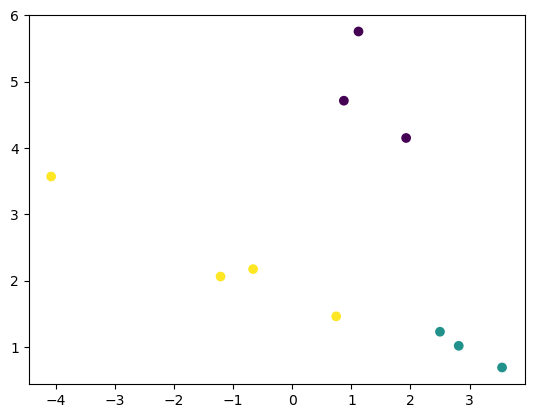

In [11]:
plt.scatter(X[:,0],X[:,1], c= y)

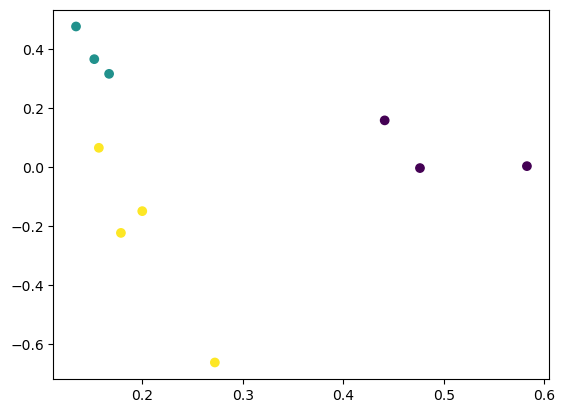

In [12]:
U,_,_ = np.linalg.svd(X)
plt.scatter(U[:,0],U[:,1], c= y)

In [13]:
import numpy as np
import scipy
import scipy.io as sio

from FlagRep import FlagRep, chordal_distance

from matplotlib import pyplot as plt

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import tqdm

import pandas as pd
import seaborn as sns

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    
    return accuracies

#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn(data_train, data_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using the training distance matrix and labels
        knn.fit(data_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(data_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

def extract_patches_of_class(data, labels, patch_size, target_class):
    """
    Extract non-overlapping patches where all pixels in the patch are of the target class.

    :param data: The hyperspectral image data 
    :param labels: The ground truth labels 
    :param patch_size: Size of the patch (e.g., 7 for 7x7 patches).
    :param target_class: The class for which patches should be extracted.
    :return: A list of patches (each patch is of size patch_size x patch_size x num_bands).
    """
    half_patch = patch_size // 2
    patches = []
    patch_labels = []

    # Iterate through the image in steps of patch_size to avoid overlap
    for i in range(half_patch, data.shape[0] - half_patch, patch_size):
        for j in range(half_patch, data.shape[1] - half_patch, patch_size):
            # Extract the patch from both the data and the labels
            label_patch = labels[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1]
            
            # Check if all pixels in the label patch are of the target class
            if np.all(label_patch == target_class):
                # Extract the corresponding data patch
                patch = data[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                patches.append(patch)
                patch_labels.append(target_class)

    return np.array(patches), np.array(patch_labels)


def extract_patches(data, labels, patch_size, class_ids, feats = 'pixels'):
    # extract patches
    mod_data = []
    mod_labels = []
    for target_class in class_ids:#[1,2,3,4,5,6,7,8,9,10,11,12,13]: #[8,10,11,14]:#[8,10,11,14]:#:
        patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)
        if len(patches) > 0:
            flat_patches = []
            for patch in patches:
                # Your 3D array of size 11x11x200
                array_3d = patch  # Example array

                center_x, center_y = patch_size//2, patch_size//2

                # Create a list of all (x, y) coordinates and compute their Manhattan distances from the center
                coords = [(x, y) for x in range(patch_size) for y in range(patch_size)]
                distances = [(x, y, max(abs(x - center_x), abs(y - center_y))) for x, y in coords]

                # Sort coordinates by distance
                sorted_coords = sorted(distances, key=lambda item: item[2])

                # Create the 2D array by unwrapping the 3D array based on sorted coordinates
                flat_patch = np.array([array_3d[x, y, :] for x, y, _ in sorted_coords])
                if feats == 'bands':
                    flat_patches.append(flat_patch)
                elif feats == 'pixels':
                    flat_patches.append(flat_patch.T)

                # Create a hierarchy vector containing the Chebyshev distances in the same sorted order
                hierarchy_vector = np.array([distance for _, _, distance in sorted_coords])

                # Find the indices where the hierarchy vector changes value
                change_indices = np.where(np.diff(hierarchy_vector) != 0)[0] + 1  # Add 1 because diff reduces length by 1

            change_indices = np.hstack([change_indices,np.array(len(hierarchy_vector))])
            mod_labels +=[target_class]*len(patches)
            
            mod_data += flat_patches

        if feats == 'pixels':
            Aset = [np.arange(i) for i in change_indices]
        elif feats == 'bands':
            Aset = [np.arange(10),np.arange(30),np.arange(100)]
        print(f"Extracted {len(patches)} patches where all pixels are of class {class_names[target_class]}. Each patch has shape {patch_size}.")
    return mod_data, mod_labels, Aset


def baseline_visuals(mod_data, mod_labels, class_names):
    #visualizations

    pca = PCA(n_components = 2)
    vis_data_pca = pca.fit_transform(np.vstack([m.flatten() for m in mod_data]))

    plt.figure()
    unique_labels = np.unique(mod_labels)
    for l in unique_labels:
        idx = np.where(mod_labels == l)
        plt.scatter(vis_data_pca[idx,0], vis_data_pca[idx,1], alpha=.5, label = class_names[l])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()

    tsne = TSNE(n_components = 2, init = "random", random_state = 10)
    vis_data_tsne = tsne.fit_transform(np.vstack([m.flatten() for m in mod_data]))

    plt.figure()
    unique_labels = np.unique(mod_labels)
    for l in unique_labels:
        idx = np.where(mod_labels == l)
        plt.scatter(vis_data_tsne[idx,0], vis_data_tsne[idx,1], alpha=.5, label = class_names[l])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.tight_layout()
    plt.show()


In [ ]:

# Load the hyperspectral image and ground truth
# data = sio.loadmat('../data/indian_pines/Indian_pines.mat')['indian_pines']  
# labels = sio.loadmat('../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  
# class_names = {1: 'Alfalfa',
#             2: 'Corn-notill',
#             3: 'Corn-mitill',
#             4: 'Corn',
#             5: 'Grass-pasture',
#             6: 'Grass-trees',
#             7: 'Grass-pasture-mowed',
#             8: 'Hay-windrowed',
#             9: 'Oats',
#             10: 'Soybean-notill',
#             11: 'Soybean-mitill',
#             12: 'Soybean-clean',
#             13: 'Wheat',
#             14: 'Woods',
#             15: 'Buildings-Grass-Trees-Drives',
#             16: 'Stone-Steel-Towers'}
# class_ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

data = sio.loadmat('../data/Salinas/Salinas.mat')['salinas']  
labels = sio.loadmat('../data/Salinas/Salinas_gt.mat')['salinas_gt']  
class_names = {
    1: "Brocoli_green_weeds_1",
    2: "Brocoli_green_weeds_2",
    3: "Fallow",
    4: "Fallow_rough_plow",
    5: "Fallow_smooth",
    6: "Stubble",
    7: "Celery",
    8: "Grapes_untrained",
    9: "Soil_vinyard_develop",
    10: "Corn_senesced_green_weeds",
    11: "Lettuce_romaine_4wk",
    12: "Lettuce_romaine_5wk",
    13: "Lettuce_romaine_6wk",
    14: "Lettuce_romaine_7wk",
    15: "Vinyard_untrained",
    16: "Vinyard_vertical_trellis"
        }
class_ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
patch_size = 5 #works
k_values = [1, 2, 3, 4, 5]
cutoff = .3

# data = scipy.io.loadmat('../data/KSC/KSC.mat')['KSC']
# labels = scipy.io.loadmat('../data/KSC/KSC_gt.mat')['KSC_gt']
# class_names = {1: 'Scrub',
#             2: 'Willow swamp',
#             3: 'Cabbage palm hammock',
#             4: 'Cabbage palm/oak hammock',
#             5: 'Slash pine',
#             6: 'Oak/broad leaf hammock',
#             7: 'Hardwood swamp',
#             8: 'Graminoid marsh',
#             9: 'Spartina marsh',
#             10: 'Cattail marsh',
#             11: 'Salt marsh',
#             12: 'Mudflats',
#             13: 'Water'}
# class_ids = [1,2,3,4,5,6,7,8,9,10,11,12,13]
# patch_size = 3
# k_values = [1, 2, 3, 4, 5]
# cutoff = .95

# patch_size = 9
# k_values = [1, 2, 3, 4, 5, 6, 7, 9]
# cutoff = .3

methods = ['FlagRep', 'SVD', 'QR', 'Euclidean']



dist_mats = {}
flag_data = {}
flag_types = {}

mod_data, mod_labels, Aset = extract_patches(data, labels, patch_size, class_ids, feats = 'pixels')

n,p = mod_data[0].shape
fl_type_easy = [i for i in range(np.min([n,p]))]
n_pts = len(mod_data)



In [ ]:
for method_name in methods:
    print(f'Starting method {method_name}')
    # make the flags
    flag_data[method_name] = []
    flag_types[method_name] = []
    for pt in tqdm.tqdm(mod_data):
        if method_name == 'FlagRep':
            flag_pt, f_type = FlagRep(pt, Aset, eps_rank = cutoff)
            flag_types[method_name].append(f_type)
        elif method_name == 'SVD':
            U,S,_ = np.linalg.svd(pt)
            s_prop = np.cumsum(S**2)/np.sum(S**2)
            idx = np.where(s_prop<cutoff)[0]
            flag_pt = U[:,idx]
            flag_types[method_name].append([len(idx)])
        elif method_name == 'QR':
            Q,_ = np.linalg.qr(pt)
            flag_pt = Q
            flag_types[method_name].append(fl_type_easy)
        elif method_name == 'Euclidean':
            flag_pt = flag_pt.flatten()
        flag_data[method_name].append(flag_pt)
        


In [ ]:
        #make distance matrices
        dist_mats[method_name] = np.zeros((n_pts,n_pts))
        for i in tqdm.tqdm(range(n_pts)):
            for j in range(i+1,n_pts):
                x = flag_data[method_name][i]
                y = flag_data[method_name][j]
                if method_name == 'Euclidean':
                    dist = np.linalg.norm(x-y)
                else:
                    fl_type_x = flag_types[method_name][i]
                    fl_type_y = flag_types[method_name][j]
                    Bs_x = make_Bs(fl_type_x)
                    Bs_y = make_Bs(fl_type_y)
                    dist = chordal_distance(x, y, Bs_x, Bs_y)
                dist_mats[method_name][i,j] = dist
                dist_mats[method_name][j,i] = dist
            
    results = pd.DataFrame(columns = ['k','Method Name', 'Accuracy', 'Seed'])

    indices = np.arange(len(mod_labels))
    mod_labels = np.array(mod_labels)

    fig,ax = plt.subplots(1,3, figsize = (25,5))
    for i, method_name in enumerate(methods[:-1]):
        tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
        vis_data = tsne.fit_transform(dist_mats[method_name])

        unique_labels = np.unique(mod_labels)
        for l in unique_labels:
            idx = np.where(mod_labels == l)
            ax[i].scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
        ax[i].set_xlabel('t-SNE1')
        ax[i].set_title(method_name)
    ax[0].set_ylabel('t-SNE2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

    fig,ax = plt.subplots(1,3)
    for i, method_name in enumerate(methods[:-1]):
        ax[i].imshow(dist_mats[method_name], cmap = 'Greys')
        ax[i].set_title(method_name)
    plt.tight_layout()
    plt.show()

    for s in range(20):

        # Step 2: Perform train-test split based on labels using the indices
        train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=s)

        # Step 3: Use these indices to retrieve the corresponding data and labels
        # (This step assumes `data` is an array of the same length as `labels`)
        for method_name in methods:

            distance_matrix_train = dist_mats[method_name][train_indices,:][:,train_indices]
            distance_matrix_test = dist_mats[method_name][test_indices,:][:,train_indices]
            y_train = mod_labels[train_indices]
            y_test = mod_labels[test_indices]

            # Step 5: Test for different values of k (number of neighbors)

            accs = evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)

            for k, acc in zip(k_values, accs):
                res = pd.DataFrame(columns = results.columns,
                                data = [[k, method_name, acc, s]])
                results = pd.concat([results,res])


    sns.boxplot(data = results, x = 'k', y = 'Accuracy', hue = 'Method Name')
    plt.show()
